In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import pydicom
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [15]:

def load_dicom_images(folder_path, target_size=(128, 128)):
    images = []
    print(f"Loading DICOM images from: {folder_path}")
    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".dicom"):
                dicom_path = os.path.join(subdir, file)
                try:
                    ds = pydicom.dcmread(dicom_path)
                    image = ds.pixel_array
                    if len(image.shape) == 3:  # Verificar si la imagen tiene 3 canales (color)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
                    image_resized = cv2.resize(image, target_size)  # Redimensionar la imagen
                    images.append(image_resized)
                except Exception as e:
                    print(f"Error reading DICOM file {dicom_path}: {e}")
    print(f"Loaded {len(images)} images from {folder_path}")
    return np.array(images)


In [16]:

# Rutas de las carpetas con las imágenes DICOM
disc_space_narrowing_path = r'D:\DESK\PATRONUS\chllng_dicom\images_dicom\Disc_space_narrowing'
foramidal_stenosis_path = r'D:\DESK\PATRONUS\chllng_dicom\images_dicom\Foramidal_steanosis'
vertebral_collapse_path = r'D:\DESK\PATRONUS\chllng_dicom\images_dicom\Vertebral_collapse'

# Cargar imágenes y redimensionarlas
images_disc_space_narrowing = load_dicom_images(disc_space_narrowing_path)
images_foramidal_stenosis = load_dicom_images(foramidal_stenosis_path)
images_vertebral_collapse = load_dicom_images(vertebral_collapse_path)

# Seleccionar 50 imágenes de cada enfermedad
images_disc_space_narrowing = images_disc_space_narrowing[:50]
images_foramidal_stenosis = images_foramidal_stenosis[:50]
images_vertebral_collapse = images_vertebral_collapse[:50]

# Crear las etiquetas
labels_disc_space_narrowing = np.full(50, 0)  # 0 para disc space narrowing
labels_foramidal_stenosis = np.full(50, 1)  # 1 para foramidal stenosis
labels_vertebral_collapse = np.full(50, 2)  # 2 para vertebral collapse

# Combinar todas las imágenes y etiquetas
images = np.concatenate((images_disc_space_narrowing, images_foramidal_stenosis, images_vertebral_collapse), axis=0)
labels = np.concatenate((labels_disc_space_narrowing, labels_foramidal_stenosis, labels_vertebral_collapse), axis=0)

# Añadir una dimensión para el canal
images = images[..., np.newaxis]

# Normalizar las imágenes
images = images / np.max(images)


Loading DICOM images from: D:\DESK\PATRONUS\chllng_dicom\images_dicom\Disc_space_narrowing


c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Loaded 50 images from D:\DESK\PATRONUS\chllng_dicom\images_dicom\Disc_space_narrowing
Loading DICOM images from: D:\DESK\PATRONUS\chllng_dicom\images_dicom\Foramidal_steanosis
Loaded 50 images from D:\DESK\PATRONUS\chllng_dicom\images_dicom\Foramidal_steanosis
Loading DICOM images from: D:\DESK\PATRONUS\chllng_dicom\images_dicom\Vertebral_collapse
Loaded 50 images from D:\DESK\PATRONUS\chllng_dicom\images_dicom\Vertebral_collapse


In [17]:

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convertir etiquetas a formato one-hot
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)


In [18]:

# Crear los generadores de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)


In [19]:

# Definir el constructor de modelos para kerastuner
def constructor_modelos(hp):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units // 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(units=hp_units, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [20]:

# Configurar el tuner
tuner = kt.Hyperband(
    constructor_modelos,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='dicom_hyperband'
)


Reloading Tuner from my_dir\dicom_hyperband\tuner0.json


In [21]:

# Buscar los mejores hiperparámetros
tuner.search(train_generator, epochs=5, validation_data=validation_generator)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el modelo con los mejores hiperparámetros
hypermodel = tuner.hypermodel.build(best_hps)


c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:

# Definir los callbacks
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [callback_early, callback_checkpoint]


In [23]:

# Entrenar el modelo con los callbacks
history_hypermodel = hypermodel.fit(
    train_generator,
    epochs=30,
    callbacks=callbacks,
    validation_data=validation_generator
)


Epoch 1/30


c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3275 - loss: 1.1012
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.3220 - loss: 1.1012 - val_accuracy: 0.3333 - val_loss: 1.1006
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.3389 - loss: 1.1007
Epoch 2: val_accuracy improved from 0.33333 to 0.36667, saving model to best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.3345 - loss: 1.1008 - val_accuracy: 0.3667 - val_loss: 1.1005
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3518 - loss: 1.0995
Epoch 3: val_accuracy did not improve from 0.36667
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.3515 - loss: 1.0994 - val_accuracy: 0.3333 - val_loss: 1.1006
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3289 - loss: 1.1003
Epoch 4: val_accuracy did not improve from 0.36667
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.

In [24]:

# Evaluar el modelo
test_loss, test_acc = hypermodel.evaluate(validation_generator)
print(f'Pérdida en el conjunto de prueba: {test_loss:.4f}')
print(f'Precisión en el conjunto de prueba: {test_acc:.4f}')

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = hypermodel.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = validation_generator.classes if hasattr(validation_generator, 'classes') else np.argmax(y_test, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3000 - loss: 1.1023
Pérdida en el conjunto de prueba: 1.1023
Precisión en el conjunto de prueba: 0.3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


In [25]:

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusión:")
print(cm)

# Generar el informe de clasificación
report = classification_report(y_true, y_pred, target_names=['Disc space narrowing', 'Foramidal stenosis', 'Vertebral collapse'])
print("Informe de clasificación:")
print(report)


Matriz de confusión:
[[ 0 10  0]
 [ 0  9  0]
 [ 0 11  0]]
Informe de clasificación:
                      precision    recall  f1-score   support

Disc space narrowing       0.00      0.00      0.00        10
  Foramidal stenosis       0.30      1.00      0.46         9
  Vertebral collapse       0.00      0.00      0.00        11

            accuracy                           0.30        30
           macro avg       0.10      0.33      0.15        30
        weighted avg       0.09      0.30      0.14        30



c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

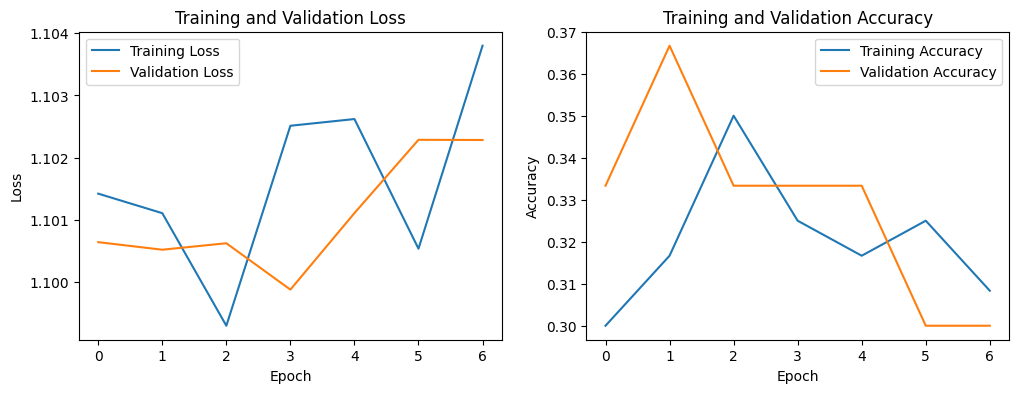

In [26]:

# Graficar las pérdidas y precisiones
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_hypermodel.history['loss'], label='Training Loss')
plt.plot(history_hypermodel.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_hypermodel.history['accuracy'], label='Training Accuracy')
plt.plot(history_hypermodel.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
